In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [3]:
words = open('data/names.txt').read().splitlines()
words = list(w.lower() for w in words)
len(words)

21985

In [12]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
block_size = 3
vocab_size = len(stoi)

In [9]:
def build_dataset(words):
    X,Y = [],[]
    context = [0]*block_size
    for w in words:
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [11]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([125725, 3]) torch.Size([125725])
torch.Size([16100, 3]) torch.Size([16100])
torch.Size([15535, 3]) torch.Size([15535])


In [27]:
n_emb = 10
n_hidden = 200

C = torch.randn((vocab_size, n_emb))
W1 = torch.randn((n_emb*block_size, n_hidden)) * (5/3)/((n_emb * block_size)**0.5)
# b1 = torch.randn(n_hidden) * 0
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(vocab_size) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print('total params: ', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

total params:  12730


In [29]:
batch_size = 32
max_steps = 200000
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain*(hpreact-bnmeani)/bnstdi+bnbias
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.001
    for p in parameters:
        p.data += -lr*p.grad
        
    if i%10000==0:
        print(f'{i}/{max_steps}, loss:{loss.item():.4f}')
    lossi.append(loss.log10().item())

0/200000, loss:3.3858
10000/200000, loss:2.7203
20000/200000, loss:2.6779
30000/200000, loss:2.4910
40000/200000, loss:2.3609
50000/200000, loss:2.4546
60000/200000, loss:2.6440
70000/200000, loss:2.2570
80000/200000, loss:2.5402
90000/200000, loss:2.3324
100000/200000, loss:2.0268
110000/200000, loss:2.1141
120000/200000, loss:2.0083
130000/200000, loss:2.4298
140000/200000, loss:2.1889
150000/200000, loss:2.0937
160000/200000, loss:1.8692
170000/200000, loss:2.0202
180000/200000, loss:2.2238
190000/200000, loss:1.9614


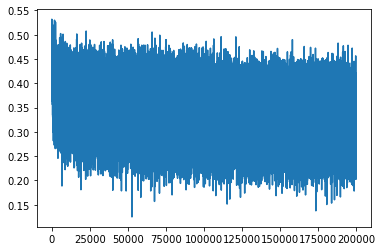

In [33]:
plt.plot(lossi);

In [38]:
with torch.no_grad():
    emb = C[Xtr]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat@W1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    

In [43]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1
    hpreact = bngain * (hpreact-bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.110860586166382
val 3.067075490951538
